In [7]:
import numpy as np
import os
import tarfile
import urllib.request

def download_and_extract_cifar():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    filename = 'cifar-10-python.tar.gz'
    foldername = 'cifar-10-batches-py'
    urllib.request.urlretrieve(url, filename)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(filename)
    print("CIFAR-10 downloaded and extracted.")

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

import random

def load_cifar10():
    cifar_folder = 'cifar-10-batches-py'
    train_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    test_files = ['test_batch']

    train_data = []
    train_labels = []
    for file in train_files:
        filepath = os.path.join(cifar_folder, file)
        batch_dict = unpickle(filepath)
        batch_data = batch_dict[b'data'].reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
        batch_labels = np.array(batch_dict[b'labels'])
        train_data.append(batch_data)
        train_labels.append(batch_labels)
    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    # Randomly select 5000 examples
    indices = random.sample(range(train_data.shape[0]), 5000)
    train_data = train_data[indices]
    train_labels = train_labels[indices]

    test_data = []
    test_labels = []
    for file in test_files:
        filepath = os.path.join(cifar_folder, file)
        batch_dict = unpickle(filepath)
        batch_data = batch_dict[b'data'].reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
        batch_labels = np.array(batch_dict[b'labels'])
        test_data.append(batch_data)
        test_labels.append(batch_labels)
    test_data = np.concatenate(test_data)
    test_labels = np.concatenate(test_labels)

    return (train_data, train_labels), (test_data, test_labels)

download_and_extract_cifar()
(x_train, y_train), (x_test, y_test) = load_cifar10()


CIFAR-10 downloaded and extracted.


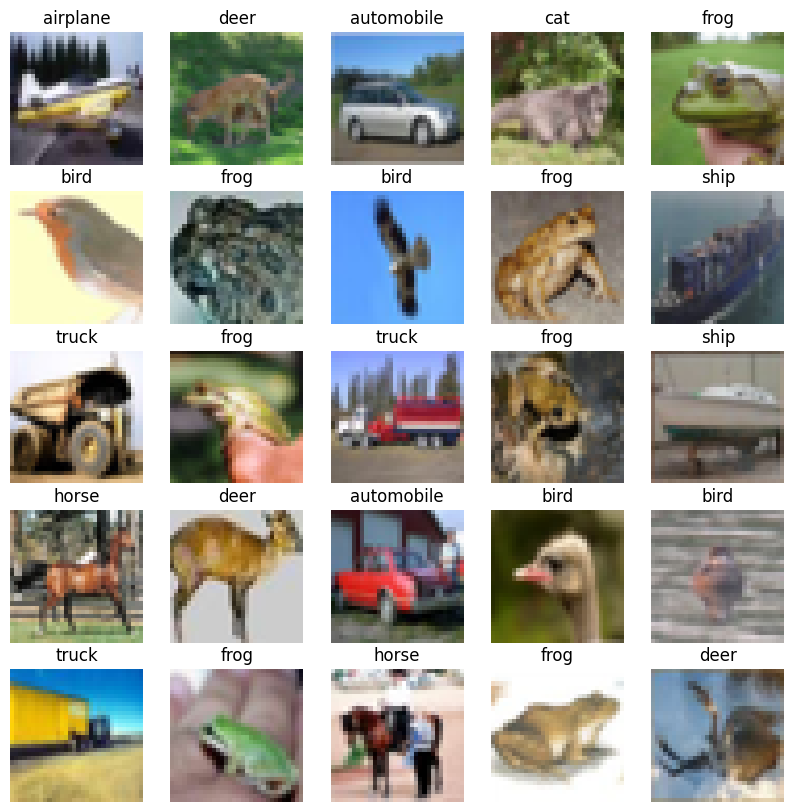

In [8]:
import matplotlib.pyplot as plt
import random

# Assuming that x_train are your CIFAR-10 training images

# The CIFAR-10 dataset has 10 classes, each of which corresponds to a specific label:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# select a random sample of 25 images
indices = random.sample(range(x_train.shape[0]), 25)

# create a grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # find the corresponding image and label
    img = x_train[indices[i]]
    lbl = y_train[indices[i]]

    # display the image and its label
    ax.imshow(img)
    ax.set_title(cifar10_labels[lbl])
    ax.axis('off')

plt.show()

## Feature extraction

In [9]:
import numpy as np

def flatten_image(image):
    return image.reshape(-1)

In [39]:
from skimage.feature import hog

def calculate_hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)):
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    return hog_features

AS HOG is usually applied to 2d greyscaled images, we must also use the rgb2gray function

In [11]:
from skimage.color import rgb2gray

x_train_gray = [rgb2gray(color_image) for color_image in x_train]
x_test_gray = [rgb2gray(color_image) for color_image in x_test]

In [12]:
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report


class FlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([flatten_image(x) for x in X])



# Define the pipeline
pipe = Pipeline([
    ('flatten', FlattenTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.39      0.37      0.38      1000
           1       0.42      0.38      0.40      1000
           2       0.25      0.26      0.26      1000
           3       0.25      0.26      0.25      1000
           4       0.28      0.24      0.26      1000
           5       0.26      0.30      0.28      1000
           6       0.36      0.40      0.38      1000
           7       0.37      0.34      0.36      1000
           8       0.41      0.48      0.44      1000
           9       0.41      0.35      0.38      1000

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000

{'clf__C': 0.01}


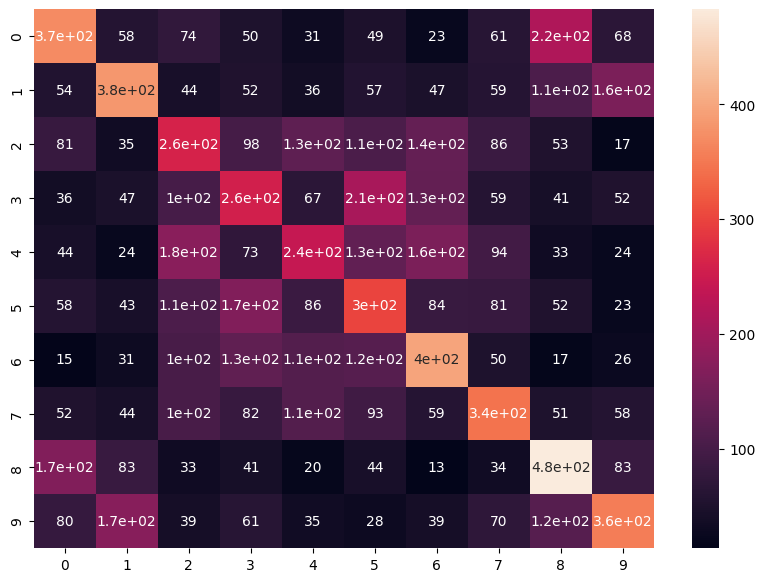

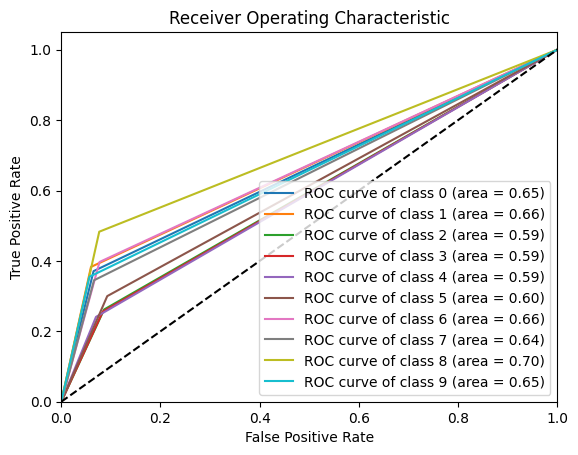

In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Logreg + Hog

In [20]:
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report



class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        def local_hog(X):
            return hog(rgb2gray(X),
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block)

        try: # parallel
            return np.array([local_hog(x) for x in X])
        except:
            return np.array([local_hog(x) for x in X])


# Define the pipeline
pipe = Pipeline([
    ('hog', HOGTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'hog__orientations': [8, 9],
    'hog__pixels_per_cell': [(8, 8), (10, 10)],
    'hog__cells_per_block': [(2, 2), (3, 3)],
    'clf__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
              precision    recall  f1-score   support

           0       0.54      0.51      0.52      1000
           1       0.55      0.58      0.57      1000
           2       0.37      0.35      0.36      1000
           3       0.37      0.28      0.32      1000
           4       0.42      0.38      0.40      1000
           5       0.40      0.42      0.41      1000
           6       0.49      0.61      0.54      1000
           7       0.52      0.54      0.53      1000
           8       0.51      0.56      0.53      1000
           9       0.59      0.56      0.57      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000

{'clf__C': 0.01, 'hog__cells_per_block': (3, 3), 'hog__orientations': 8, 'hog__pixels_per_cell': (8, 8)}


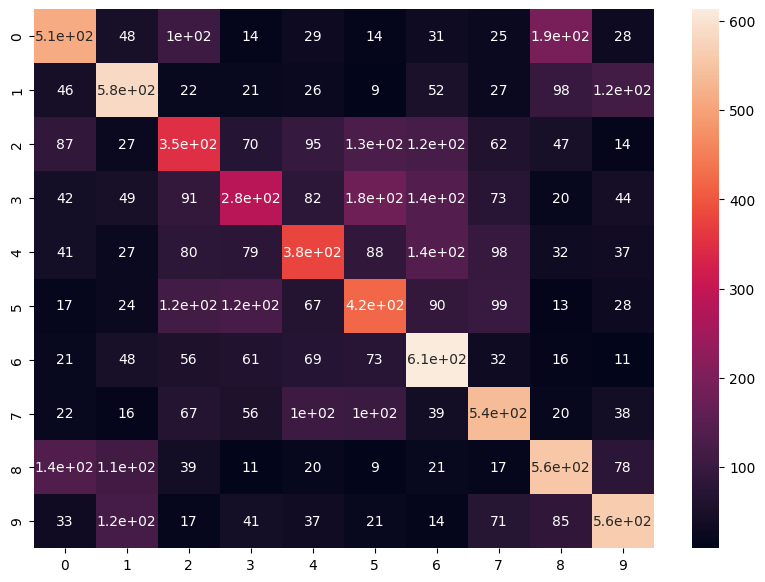

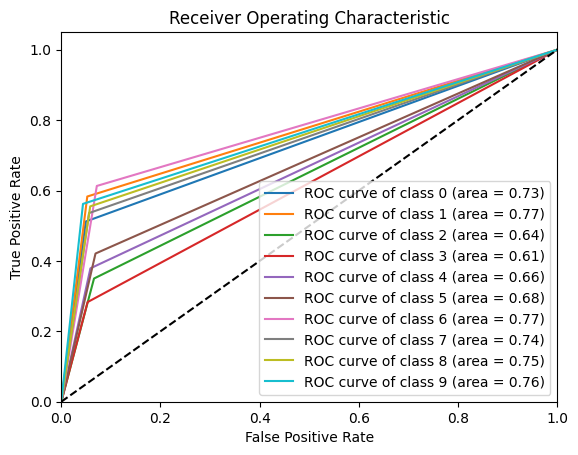

In [21]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## LOGREG + SOBEL

In [22]:
from skimage.filters import sobel
from skimage.color import rgb2gray

class SobelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        edge_images = []
        for img in X:
            gray = rgb2gray(img)
            edge_sobel = sobel(gray)
            edge_images.append(edge_sobel.flatten())
        return np.array(edge_images)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipe = Pipeline([
    ('sobel', SobelTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
              precision    recall  f1-score   support

           0       0.34      0.33      0.34      1000
           1       0.29      0.29      0.29      1000
           2       0.25      0.33      0.29      1000
           3       0.18      0.16      0.17      1000
           4       0.23      0.22      0.22      1000
           5       0.22      0.22      0.22      1000
           6       0.26      0.22      0.24      1000
           7       0.22      0.22      0.22      1000
           8       0.30      0.35      0.32      1000
           9       0.26      0.24      0.25      1000

    accuracy                           0.26     10000
   macro avg       0.26      0.26      0.26     10000
weighted avg       0.26      0.26      0.26     10000

{'clf__C': 0.01}


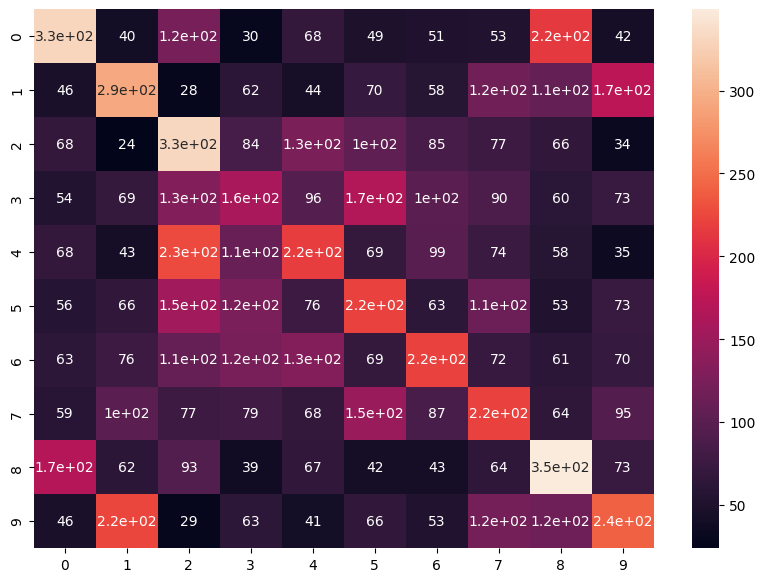

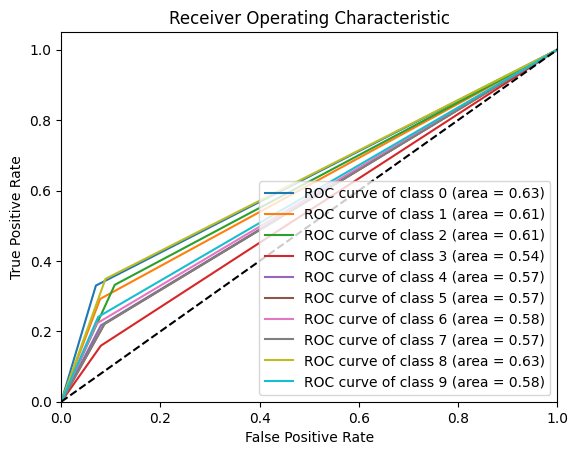

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

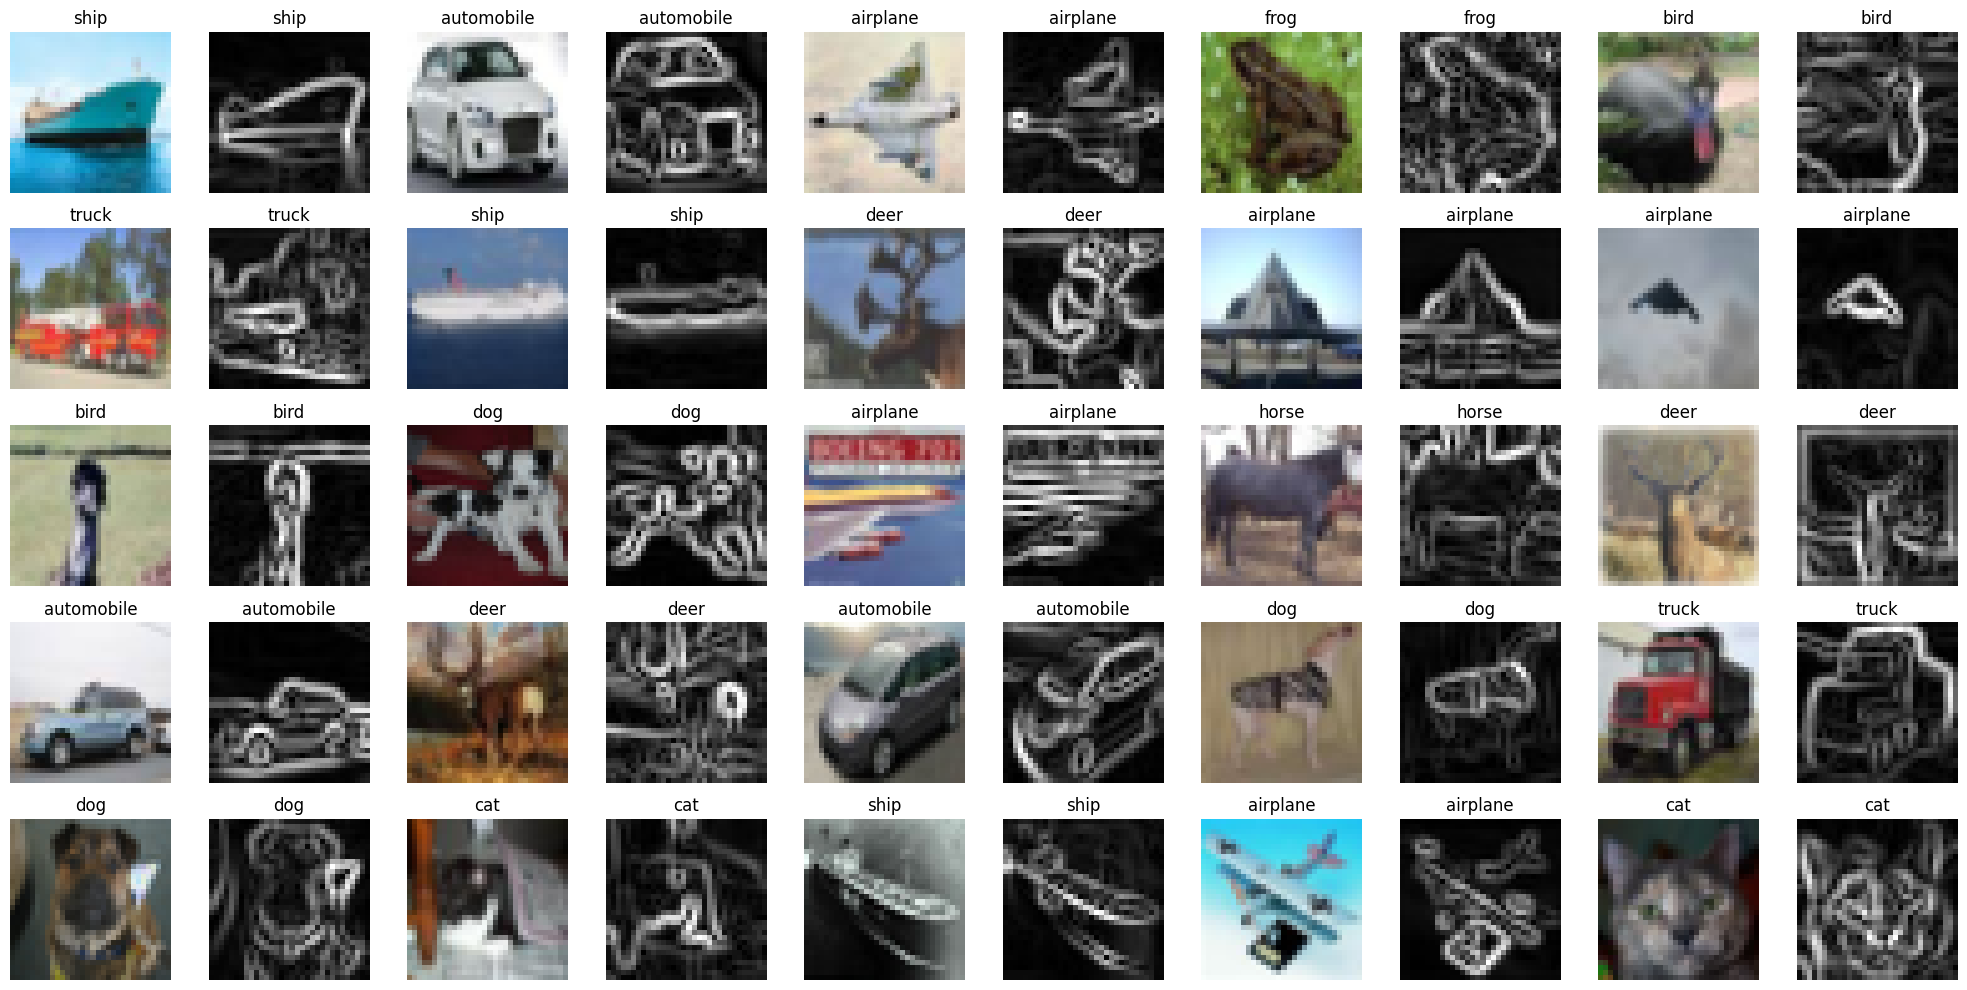

In [26]:
import matplotlib.pyplot as plt

# Define the number of pairs (original image and transformed image) per row
pairs_per_row = 5

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Choose a random subset of your data
indices = np.random.choice(len(x_train), size=pairs_per_row**2, replace=False)
subset = x_train[indices]
subset_labels = y_train[indices]  # Get the corresponding labels

# Use the pipeline to transform the data
transformed_subset = SobelTransformer().transform(subset)

# Reshape the data back into its original shape for visualization
reshaped_subset = transformed_subset.reshape(-1, 32, 32)

# Plot the original images and their transformed counterparts
fig, axes = plt.subplots(pairs_per_row, pairs_per_row * 2, figsize=(20, 10))  # We now need twice as many columns

for i in range(pairs_per_row**2):
    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2  # Columns are allocated in pairs

    # Original image
    axes[row, col].imshow(subset[i])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'{cifar10_labels[subset_labels[i]]}')

    # Transformed image
    axes[row, col+1].imshow(reshaped_subset[i], cmap='gray')
    axes[row, col+1].axis('off')
    axes[row, col+1].set_title(f'{cifar10_labels[subset_labels[i]]}')

plt.tight_layout()
plt.show()

Dans le contexte de notre expérience, la technique de détection de contours Sobel a produit des résultats inférieurs par rapport à une simple aplatissement de l'image. Étant donné que Sobel est un type de filtre de détection de contours, il met l'accent sur les zones de l'image présentant une fréquence spatiale élevée, ce qui correspond aux contours. Cela peut être très bénéfique pour certaines tâches de classification d'images, en particulier celles dans lesquelles les informations sur les contours sont essentielles.

Cependant, dans l'ensemble de données CIFAR-10, les détails importants pourraient ne pas être capturés uniquement par les contours. CIFAR-10 contient des images de 10 classes différentes telles que des avions, des voitures, des oiseaux, des chats, des cerfs, des chiens, des grenouilles, des chevaux, des navires et des camions. Les caractéristiques distinctives de ces classes ne se limitent pas à leurs contours, mais incluent également la texture, la couleur et d'autres éléments qui sont perdus lors de l'application de la détection de contours.

Par exemple, distinguer un camion d'une voiture pourrait dépendre davantage de la forme et de la présence de composants spécifiques (par exemple, la benne du camion) que des contours. De même, distinguer un oiseau d'un avion pourrait dépendre davantage de la texture et de la couleur que des seuls contours.

De plus, le filtre Sobel génère un vecteur de caractéristiques de la même longueur que l'image aplatie, ce qui pourrait entraîner un espace de caractéristiques de grande dimension. Cela augmente le risque de surajustement, en particulier avec un ensemble de données relativement petit comme CIFAR-10. La régression logistique, en tant que modèle linéaire, peut avoir du mal avec cette grande dimensionalité.

## RF + Flat

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
pipe = Pipeline([
    ('hog', FlattenTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', RandomForestClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],  # number of trees in the forest
    'clf__max_depth': [10, 20],  # maximum depth of the tree
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=4, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
              precision    recall  f1-score   support

           0       0.51      0.46      0.48      1000
           1       0.49      0.46      0.48      1000
           2       0.31      0.31      0.31      1000
           3       0.30      0.23      0.26      1000
           4       0.38      0.35      0.36      1000
           5       0.36      0.38      0.37      1000
           6       0.41      0.50      0.45      1000
           7       0.45      0.40      0.43      1000
           8       0.49      0.60      0.54      1000
           9       0.44      0.47      0.45      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000

{'clf__max_depth': 20, 'clf__n_estimators': 200}


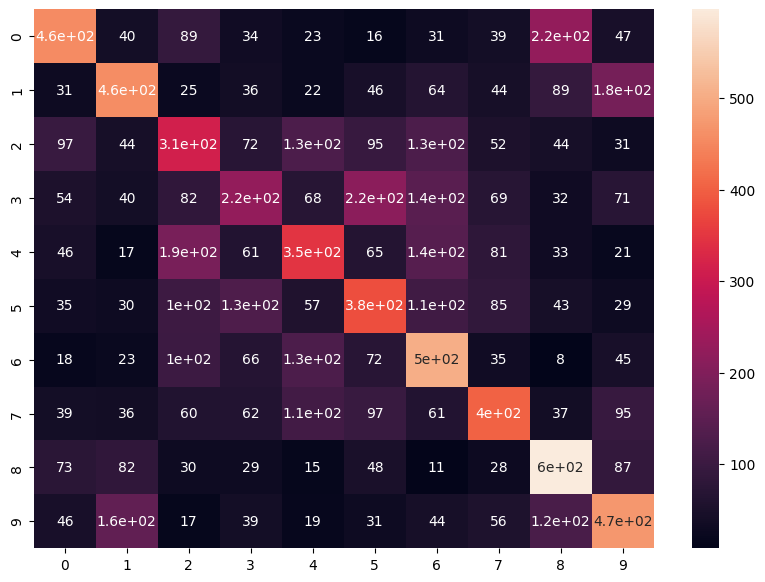

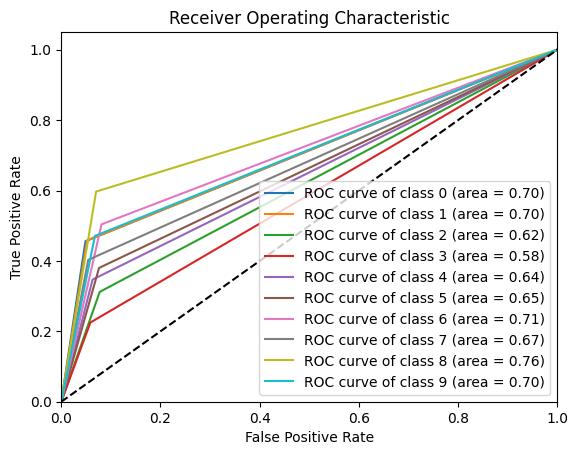

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **RF** + HOG

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
pipe = Pipeline([
    ('hog', HOGTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', RandomForestClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'hog__orientations': [8, 9],
    'hog__pixels_per_cell': [(8, 8), (10, 10)],
    'hog__cells_per_block': [(2, 2), (3, 3)],
    'clf__n_estimators': [100, 200],  # number of trees in the forest
    'clf__max_depth': [10, 20],  # maximum depth of the tree
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=1, n_jobs=-1, refit=True)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
              precision    recall  f1-score   support

           0       0.56      0.47      0.51      1000
           1       0.54      0.58      0.56      1000
           2       0.40      0.29      0.34      1000
           3       0.34      0.21      0.26      1000
           4       0.40      0.35      0.37      1000
           5       0.38      0.45      0.41      1000
           6       0.46      0.67      0.55      1000
           7       0.47      0.51      0.49      1000
           8       0.49      0.63      0.55      1000
           9       0.57      0.50      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000

{'clf__max_depth': 20, 'clf__n_estimators': 200, 'hog__cells_per_block': (3, 3), 'hog__orientations': 9, 'hog__pixels_per_cell': (10, 10)}


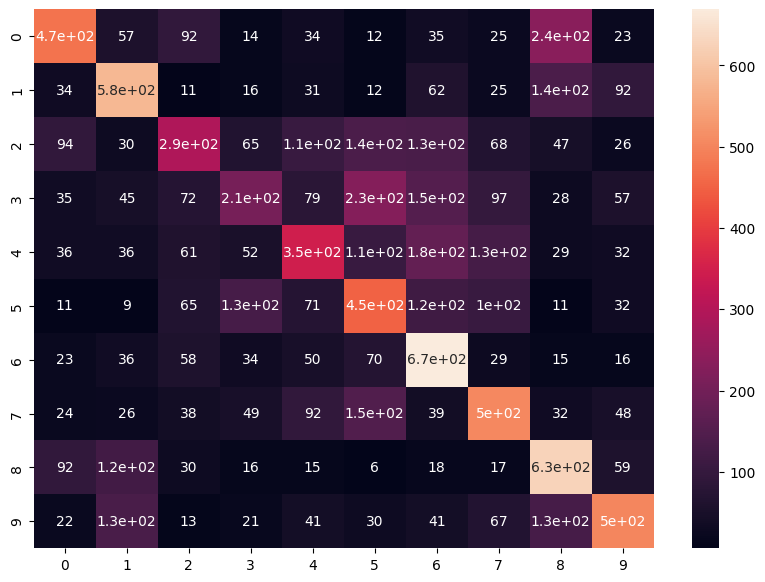

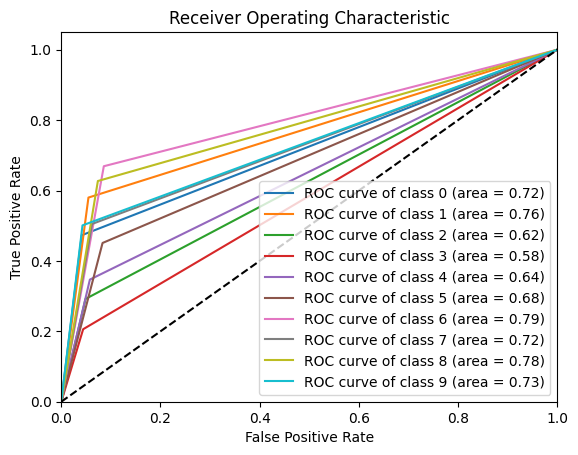

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

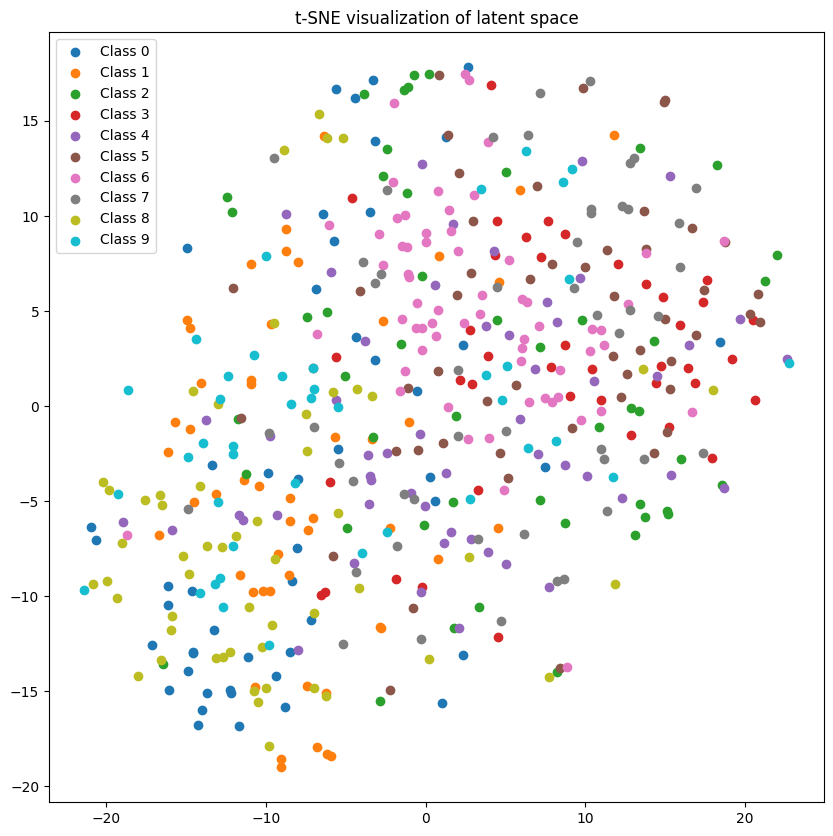

In [41]:
# Assuming 'pipe' is your final model after tuning
hog_t = HOGTransformer(orientations= 9, pixels_per_cell =(10, 10), cells_per_block= (3, 3))

# Transform a subset of training data to visualize
x_subset = x_train[:500]
x_subset_transformed = hog_t.transform(x_subset)

# Compute t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
x_subset_2d = tsne.fit_transform(x_subset_transformed)

# Plot t-SNE
plt.figure(figsize=(10, 10))
for i in range(10):  # assuming 10 classes
    indices = (y_train[:500] == i)
    plt.scatter(x_subset_2d[indices, 0], x_subset_2d[indices, 1], label=f'Class {i}')

plt.legend()
plt.title('t-SNE visualization of latent space')
plt.show()

## RF + SOBEL

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
pipe = Pipeline([
    ('sobel', SobelTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', RandomForestClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],  # number of trees in the forest
    'clf__max_depth': [10, 20, 30],  # maximum depth of the tree
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=1, n_jobs=-1, refit=True)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
              precision    recall  f1-score   support

           0       0.49      0.36      0.42      1000
           1       0.35      0.45      0.40      1000
           2       0.30      0.30      0.30      1000
           3       0.20      0.07      0.11      1000
           4       0.31      0.31      0.31      1000
           5       0.23      0.24      0.24      1000
           6       0.28      0.45      0.35      1000
           7       0.32      0.30      0.31      1000
           8       0.36      0.44      0.39      1000
           9       0.33      0.28      0.30      1000

    accuracy                           0.32     10000
   macro avg       0.32      0.32      0.31     10000
weighted avg       0.32      0.32      0.31     10000

{'clf__max_depth': 10, 'clf__n_estimators': 200}


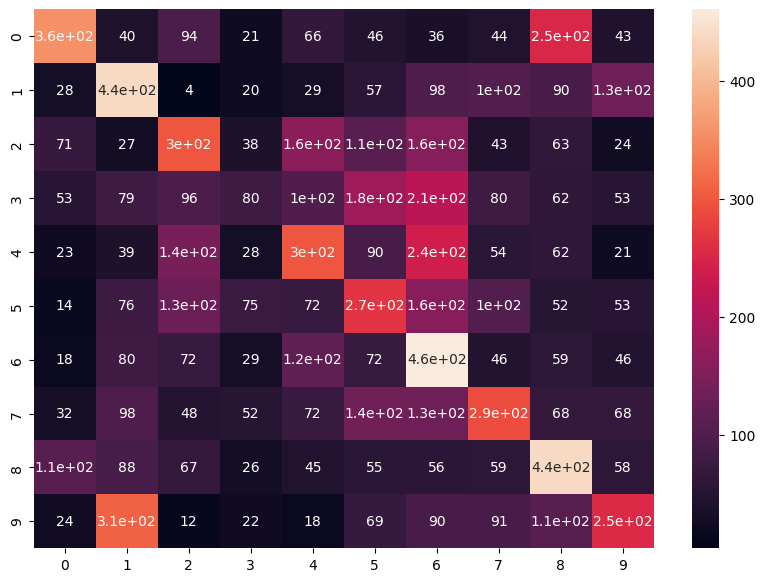

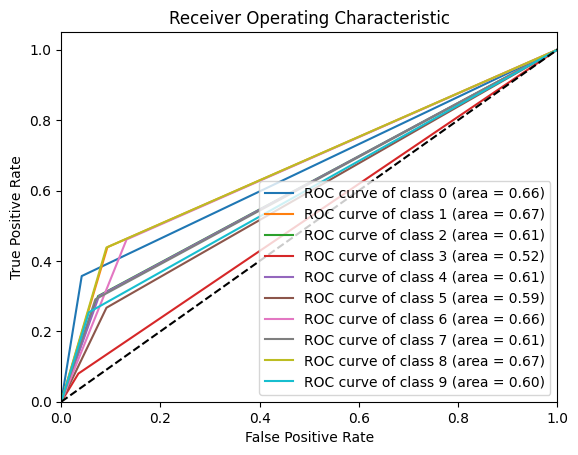

In [43]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## KNN + Flat

In [47]:
from sklearn.neighbors import KNeighborsClassifier

# Define the pipeline
pipe = Pipeline([
    ('hog', FlattenTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_neighbors' : [5,11,15],
    'clf__weights' : ['uniform','distance'],
    'clf__metric' : ['minkowski','euclidean','manhattan']
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=4, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      1000
           1       0.64      0.16      0.26      1000
           2       0.20      0.37      0.26      1000
           3       0.24      0.17      0.20      1000
           4       0.21      0.46      0.29      1000
           5       0.36      0.21      0.26      1000
           6       0.30      0.24      0.27      1000
           7       0.49      0.22      0.31      1000
           8       0.37      0.62      0.46      1000
           9       0.59      0.16      0.25      1000

    accuracy                           0.31     10000
   macro avg       0.38      0.31      0.30     10000
weighted avg       0.38      0.31      0.30     10000

{'clf__metric': 'manhattan', 'clf__n_neighbors': 5, 'clf__weights': 'distance'}


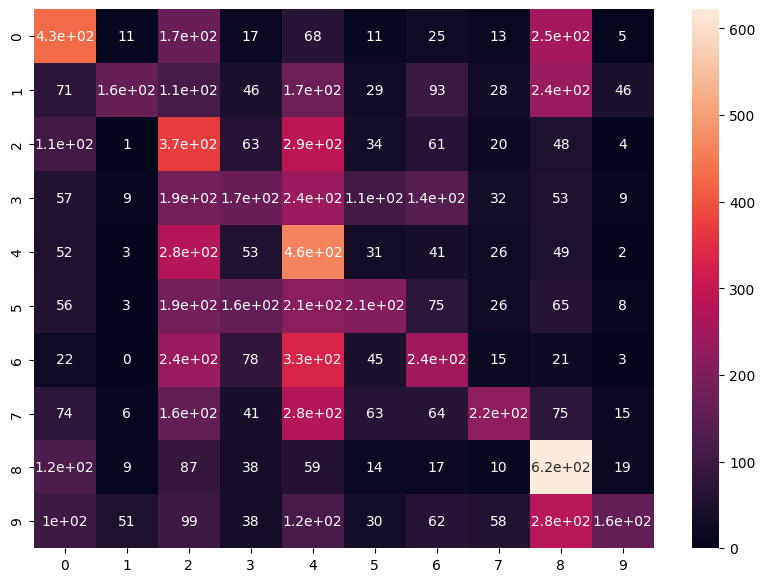

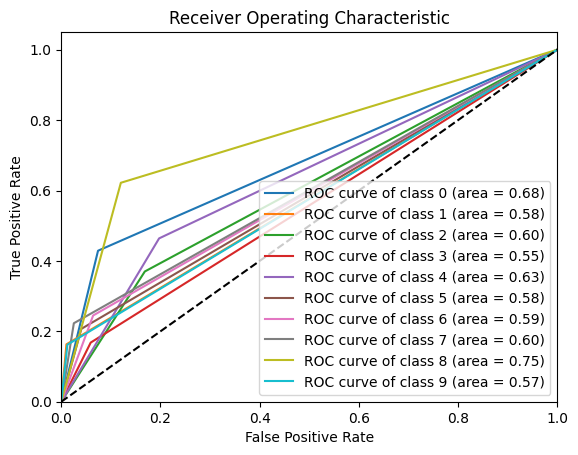

In [48]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## KNN + HOG

In [51]:
from sklearn.neighbors import KNeighborsClassifier

# Define the pipeline
pipe = Pipeline([
    ('hog', HOGTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', KNeighborsClassifier())

])

# Define the parameter grid for GridSearchCV
param_grid = {
    'hog__orientations': [8, 9],
    'hog__pixels_per_cell': [(8, 8), (10, 10)],
    'hog__cells_per_block': [(2, 2), (3, 3)],
    'clf__n_neighbors' : [5,11,15],
    'clf__weights' : ['uniform','distance'],
    'clf__metric' : ['minkowski','euclidean','manhattan']
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=1, n_jobs=-1, refit=True)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
              precision    recall  f1-score   support

           0       0.61      0.43      0.50      1000
           1       0.60      0.60      0.60      1000
           2       0.41      0.35      0.38      1000
           3       0.38      0.15      0.21      1000
           4       0.34      0.43      0.38      1000
           5       0.42      0.33      0.37      1000
           6       0.42      0.72      0.53      1000
           7       0.61      0.52      0.56      1000
           8       0.45      0.72      0.56      1000
           9       0.61      0.52      0.56      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.47     10000
weighted avg       0.49      0.48      0.47     10000

{'clf__metric': 'manhattan', 'clf__n_neighbors': 11, 'clf__weights': 'distance', 'hog__cells_per_block': (3, 3), 'hog__orientations': 9, 'hog__pixels_per_cell': (8, 8)}


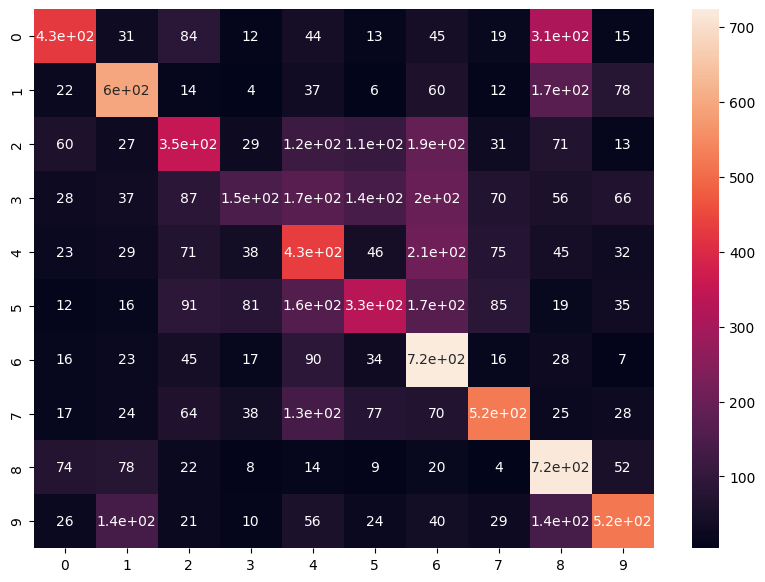

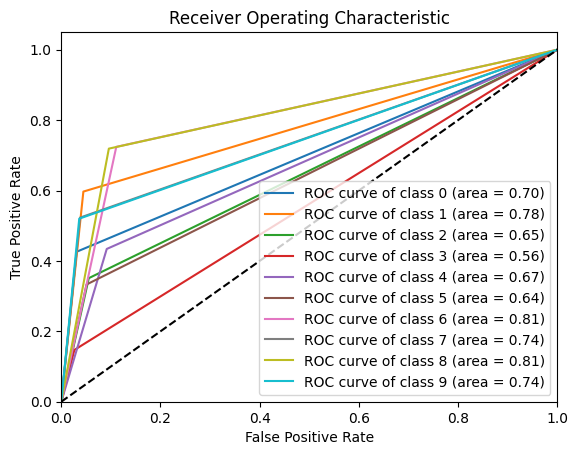

In [53]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## KNN + Sobel

In [59]:
from sklearn.neighbors import KNeighborsClassifier

# Define the pipeline
pipe = Pipeline([
    ('hog', SobelTransformer()),
    ('scaler', preprocessing.StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_neighbors' : [5,11,15],
    'clf__weights' : ['uniform','distance'],
    'clf__metric' : ['minkowski','euclidean','manhattan']
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=2, verbose=4, n_jobs=-1)

# Fit GridSearchCV
grid.fit(x_train, y_train)

# Evaluate on the test set
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))

# Print the best parameters
print(grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
              precision    recall  f1-score   support

           0       0.53      0.29      0.37      1000
           1       0.59      0.11      0.19      1000
           2       0.23      0.32      0.27      1000
           3       0.14      0.07      0.10      1000
           4       0.17      0.58      0.26      1000
           5       0.27      0.08      0.12      1000
           6       0.21      0.50      0.30      1000
           7       0.53      0.07      0.13      1000
           8       0.36      0.38      0.36      1000
           9       0.47      0.05      0.09      1000

    accuracy                           0.24     10000
   macro avg       0.35      0.24      0.22     10000
weighted avg       0.35      0.24      0.22     10000

{'clf__metric': 'manhattan', 'clf__n_neighbors': 11, 'clf__weights': 'distance'}


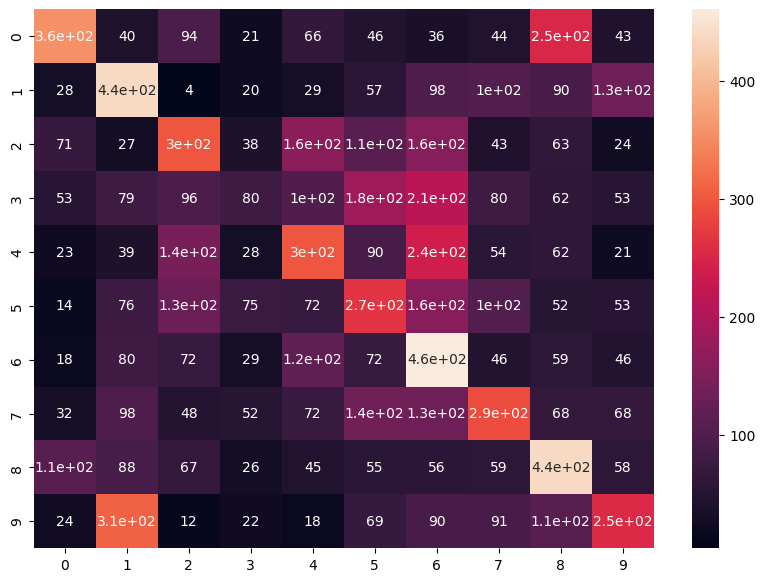

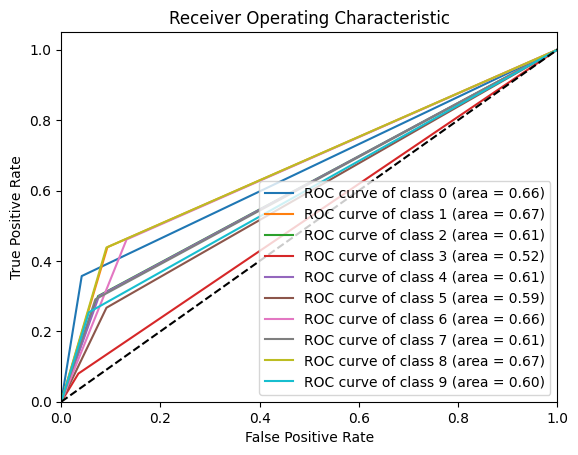

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# ROC curve (Note: this is applicable for binary classification problems. For multi-class, it's a bit more complicated)
from sklearn.metrics import roc_curve, auc

# One-hot encode the labels
y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()